In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import os.path
from os import path
from sklearn.metrics import mean_squared_error
from math import sqrt

/home/zeus/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zeus/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
def start():
    if(path.exists('reduced_dataset_for_LSTM.csv')==True):
        return 
    df=pd.read_csv('household_power_consumption.txt', delimiter=';')
    df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
    df = df.dropna(subset=['Global_active_power'])
    df['date_time']=pd.to_datetime(df['date_time']) 
    df['year'] = df['date_time'].apply(lambda x: x.year)
    df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
    df['month'] = df['date_time'].apply(lambda x: x.month)
    df['day'] = df['date_time'].apply(lambda x: x.day)
    df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
    df.sort_values('date_time', inplace=True, ascending=True)
    df = df.reset_index(drop=True)
    df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
    df["weekday"] = (df["weekday"] < 5).astype(int)
    df.to_csv('reduced_dataset_for_LSTM.csv')
    return df

In [3]:
def resume():
    df=pd.read_csv('reduced_dataset_for_LSTM.csv')
    return df

In [4]:
df=start()  # Running first time this may take some time 

In [5]:
df=resume()   # Sir this may take time

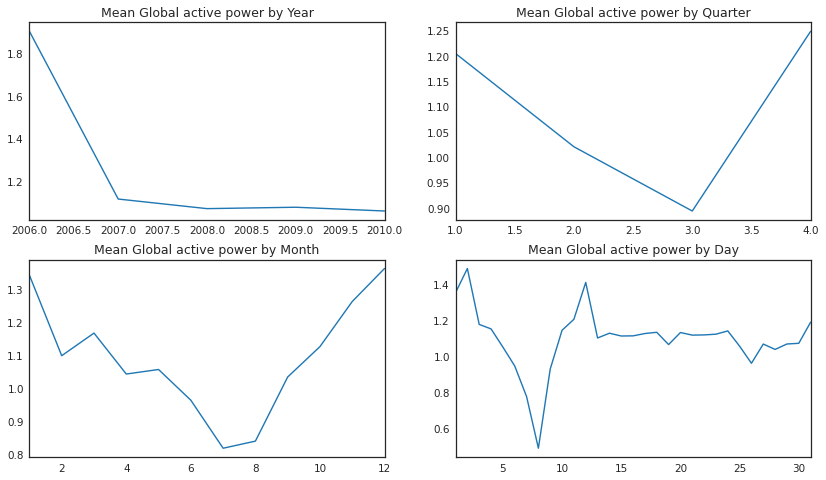

In [6]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

In [7]:
dataset = df.Global_active_power.values
dataset = dataset.astype('float32')

In [8]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [9]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

In [10]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
X_train.shape
Y_train.shape
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

(1639393,)

In [11]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=look_back))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [12]:
model.fit(X_train,Y_train, epochs=5, verbose=0)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [14]:
def Prediction_function(X_test):
    r=list()
    for i in range(len(X_test)):
        x_input=X_test[i].reshape(1,look_back)
        yhat = model.predict(x_input, verbose=0)
        r.append(yhat)
    return array(r)

In [15]:
answer=Prediction_function(X_test)

In [16]:
answer_Train=Prediction_function(X_train)#take time around 15 min because 3 year dataset

In [17]:
def Show_Diffrence(answer,Y_test):
    for i in range(len(Y_test)):
        print(Y_test[i],answer[i][0][0])


In [18]:
#Show_Diffrence(answer,Y_test)

In [19]:
#Show_Diffrence(answer_Train,Y_train)

In [20]:
answer=answer.reshape(len(answer),)
answer_Train=answer_Train.reshape(len(answer_Train),)

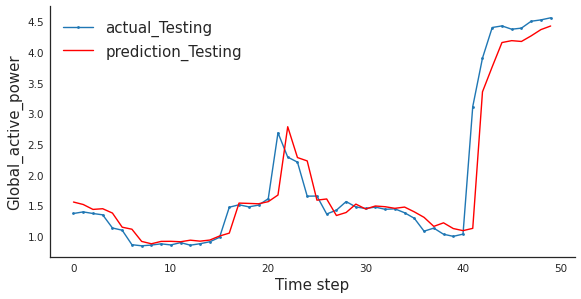

In [21]:
aa=[x for x in range(50)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:50], marker='.', label="actual_Testing")
plt.plot(aa, answer[:50], 'r', label="prediction_Testing")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

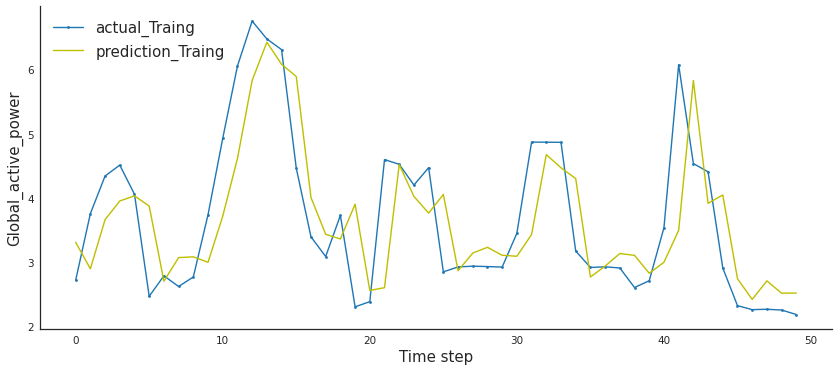

In [22]:
aa=[x for x in range(50)]
plt.figure(figsize=(12,5))
plt.plot(aa, Y_train[:50], marker='.', label="actual_Traing")
plt.plot(aa, answer_Train[:50], 'y', label="prediction_Traing")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [23]:
Y_test=Y_test.reshape(len(Y_test),)
Y_train=Y_train.reshape(len(Y_train),)

In [24]:
rms_test = sqrt(mean_squared_error(Y_test,answer))
rms_train= sqrt(mean_squared_error(Y_train,answer_Train))

In [25]:
print('Root mean Squre Error of Testing : '+str(rms_test))

Root mean Squre Error of Testing : 0.2189748323874339


In [26]:
print('Root mean Squre Error of Training : '+str(rms_train))

Root mean Squre Error of Training : 0.26145159907742926


In [27]:
def Root_Mean_Squre_Error(answer,Y_test):
    squre_sum=0;
    for index in range(len(answer)):
        squre_sum=squre_sum+abs(answer[index]-Y_test[index])**2
    mean_squre_error=squre_sum/len(answer)
    return sqrt(mean_squre_error)
        

In [28]:
Error=Root_Mean_Squre_Error(answer,Y_test)

In [29]:
Error

0.2189748514978819